# Imports

In [1]:
import pandas as pd
import biogeme.database as db
import biogeme.biogeme as bio
from biogeme.expressions import Beta, Variable, exp, Expression
from biogeme.models import loglogit
from biogeme.tools import likelihood_ratio_test
from biogeme.results import compile_estimation_results
from biogeme.models import loglogit,  boxcox
from biogeme.models.piecewise import piecewise_formula
from biogeme.models import lognested
from biogeme.nests import OneNestForNestedLogit, NestsForNestedLogit
from biogeme.biogeme import BIOGEME

import pickle

import numpy as np
import os

from scipy.stats import chi2

# Data & Variables

In [2]:
# Define the relative path to the data folder
file_path = os.path.join(os.pardir, 'lpmc01.dat')

#file_path = os.path.join(data_folder, 'lpmc01.dat')

df = pd.read_csv(file_path, sep = '\t')
df['age_normalized'] = (df['age'] - df['age'].mean()) / df['age'].std()
df['age_scaled'] = df['age'] / df['age'].max()
df['cost_driving'] = df['cost_driving_ccharge'] + df['cost_driving_fuel']
df['dur_pt'] = df['dur_pt_access'] + df['dur_pt_rail'] + df['dur_pt_int'] + df['dur_pt_bus']

database1 = db.Database('lpmc01', df)


# Define the given veriables 
dur_pt = Variable('dur_pt')
cost_driving = Variable('cost_driving')
age_scaled = Variable('age_scaled')
trip_id = Variable('trip_id')
household_id = Variable('household_id')
person_n = Variable('person_n')
trip_n = Variable('trip_n')
travel_mode = Variable('travel_mode')
purpose = Variable('purpose')
fueltype = Variable('fueltype')
faretype = Variable('faretype')
bus_scale = Variable('bus_scale')
survey_year = Variable('survey_year')
travel_year = Variable('travel_year')
travel_month = Variable('travel_month')
travel_date = Variable('travel_date')
day_of_week = Variable('day_of_week')
start_time = Variable('start_time')
age = Variable('age')
female = Variable('female')
driving_license = Variable('driving_license')
car_ownership = Variable('car_ownership')
distance = Variable('distance')
dur_walking = Variable('dur_walking')
dur_cycling = Variable('dur_cycling')
dur_pt_access = Variable('dur_pt_access') # Predicted total access and egress time for public transport route in hours
dur_pt_rail = Variable('dur_pt_rail')
dur_pt_bus = Variable('dur_pt_bus')
dur_pt_int = Variable('dur_pt_int') # Time taken (hrs) at each interchange point
pt_interchanges = Variable('pt_interchanges')   # Number of interchange points in public transport route
dur_driving = Variable('dur_driving')
cost_transit = Variable('cost_transit')
cost_driving_fuel = Variable('cost_driving_fuel')   # Estimated fuel cost of driving route in GBP
cost_driving_ccharge = Variable('cost_driving_ccharge')  # Estimated congestion charge cost of driving route in GBP
driving_traffic_percent = Variable('driving_traffic_percent')



# Define transport availability
# Assume pt, walking, cycle always available, with car availability depending on number of cars per household. From the data, 
# people without driving licenses choose driving as their mode of transport (eg. row 28). 
av_drive =  (car_ownership > 0)
av_pt =1
av_walk = 1
av_cycle = 1

variable_names = ['dur_pt', 'cost_driving', 'age_scaled']  # Replace with your variable name
for variable_name in variable_names:
    if variable_name in database1.data.columns:
        print(f"'{variable_name}' exists in the database.")
    else:
        print(f"'{variable_name}' does NOT exist in the database.")



# Define pt_cost (not needed)
# Original paper, page 31: "Public transport fares are determined for single trips using Oystercard/contactless payment."
# Therefore, cost_transit should already consider faretype and bus_scale

database = db.Database('lpmc01', df)
variable_names = ['dur_pt', 'cost_driving', 'age_scaled']  # Replace with your variable name
for variable_name in variable_names:
    if variable_name in database1.data.columns:
        print(f"'{variable_name}' exists in the database.")
    else:
        print(f"'{variable_name}' does NOT exist in the database.")

# Define driving cost
cost_driving = cost_driving_ccharge + cost_driving_fuel

# Define time taken by each mode of transport
dur_pt = dur_pt_access + dur_pt_int + dur_pt_bus + dur_pt_rail  # Public transport (external) time 

'dur_pt' exists in the database.
'cost_driving' exists in the database.
'age_scaled' exists in the database.
'dur_pt' exists in the database.
'cost_driving' exists in the database.
'age_scaled' exists in the database.


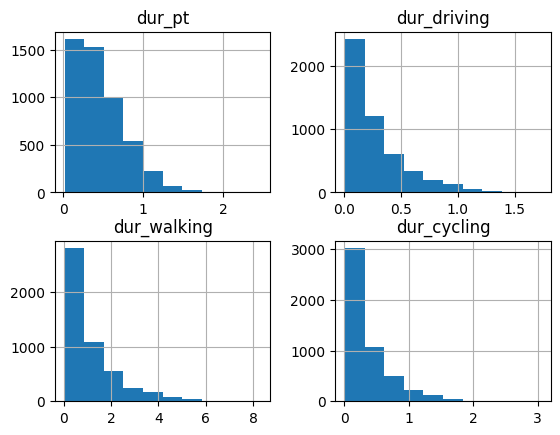

In [3]:
hist = df[['dur_pt','dur_driving','dur_walking','dur_cycling']].hist()


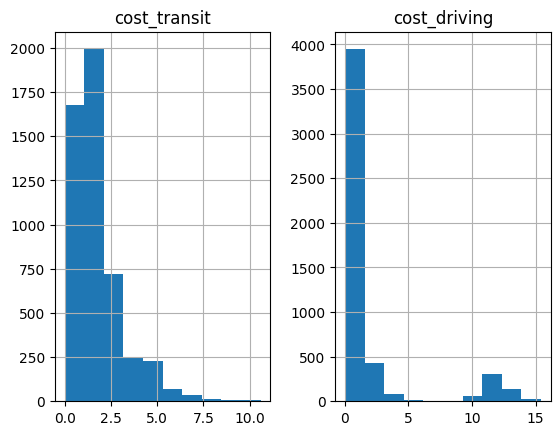

In [5]:
hist = df[['cost_transit','cost_driving']].hist()


# Model Definition

In [4]:
# Assume every mode of transport is available
availability_walk = 1  
availability_cycle = 1  
availability_pt = 1     
availability_drive = 1

availability = {
    1: availability_walk,   # Walking
    2: availability_cycle,  # Cycling
    3: availability_pt,     # Public Transport
    4: availability_drive   # Driving
}

In [5]:
# # MODEL 3


# # Define driving cost
# cost_driving = cost_driving_ccharge + cost_driving_fuel

# # Define time taken by each mode of transport
# dur_pt = dur_pt_access + dur_pt_int + dur_pt_bus + dur_pt_rail  # Public transport (external) time 

# time_pt = dur_pt
# time_cycling = dur_cycling
# time_walking = dur_walking  
# time_driving = dur_driving

# # Model normalized with asc_walking = 0
# asc_pt = Beta(name='asc_pt', value=0, lowerbound=None, upperbound=None, status=0)
# asc_cycling = Beta(name='asc_cycling', value=0, lowerbound=None, upperbound=None, status=0)
# asc_driving = Beta(name='asc_driving', value=0, lowerbound=None, upperbound=None, status=0)


# beta_cost = Beta(name='beta_cost', value=0, lowerbound=None, upperbound=None, status=0)
# beta_tt_walking = Beta(name='beta_tt_walking', value=0, lowerbound=None, upperbound=None, status=0)
# beta_tt_walking_interact = age_scaled * Beta(name='beta_tt_walking_interact', value=0, lowerbound=None, upperbound=None, status=0)
# beta_tt_cycling = Beta(name='beta_tt_cycling', value=0, lowerbound=None, upperbound=None, status=0)
# beta_tt_cycling_interact = age_scaled * Beta(name='beta_tt_cycling_interact', value=0, lowerbound=None, upperbound=None, status=0)
# beta_tt_pt = Beta(name='beta_tt_pt', value=0, lowerbound=None, upperbound=None, status=0)
# beta_tt_pt_interact = age_scaled * Beta(name='beta_tt_pt_interact', value=0, lowerbound=None, upperbound=None, status=0)
# beta_tt_driving = Beta(name='beta_tt_driving', value=0, lowerbound=None, upperbound=None, status=0)

# cost_drive_power = power_series(cost_driving)
# cost_pt_power = power_series(cost_transit)

# #mx_age = df['age'].max()

# v_walking = (time_walking * 
#                 (beta_tt_walking + beta_tt_walking_interact * age_scaled))

# v_cycling = (asc_cycling 
#              + time_cycling * 
#                 (beta_tt_cycling + beta_tt_cycling_interact * age_scaled))

# v_pt = (asc_pt 
#         + time_pt * 
#             (beta_tt_pt + beta_tt_pt_interact * age_scaled) 
#         + beta_cost * cost_pt_power)

# v_driving = (asc_driving 
#              + beta_tt_driving * time_driving 
#              + beta_cost * cost_drive_power)

# V = {1: v_walking, 2: v_cycling, 3: v_pt, 4: v_driving}

# model_3 = loglogit(V, None, travel_mode)

In [6]:
# # MODEL 3


# # Define driving cost
# cost_driving = cost_driving_ccharge + cost_driving_fuel

# # Define time taken by each mode of transport
# dur_pt = dur_pt_access + dur_pt_int + dur_pt_bus + dur_pt_rail  # Public transport (external) time 

# time_pt = dur_pt
# time_cycling = dur_cycling
# time_walking = dur_walking  
# time_driving = dur_driving

# # Model normalized with asc_walking = 0
# asc_pt = Beta(name='asc_pt', value=0, lowerbound=None, upperbound=None, status=0)
# asc_cycling = Beta(name='asc_cycling', value=0, lowerbound=None, upperbound=None, status=0)
# asc_driving = Beta(name='asc_driving', value=0, lowerbound=None, upperbound=None, status=0)

# beta_cost = Beta(name='beta_cost', value=0, lowerbound=None, upperbound=None, status=0)
# beta_tt_walking = Beta(name='beta_tt_walking', value=0, lowerbound=None, upperbound=None, status=0)
# beta_tt_walking_interact = Beta(name='beta_tt_walking_interact', value=0, lowerbound=None, upperbound=None, status=0)
# beta_tt_cycling = Beta(name='beta_tt_cycling', value=0, lowerbound=None, upperbound=None, status=0)
# beta_tt_cycling_interact = Beta(name='beta_tt_cycling_interact', value=0, lowerbound=None, upperbound=None, status=0)
# beta_tt_pt = Beta(name='beta_tt_pt', value=0, lowerbound=None, upperbound=None, status=0)
# beta_tt_pt_interact = Beta(name='beta_tt_pt_interact', value=0, lowerbound=None, upperbound=None, status=0)
# beta_tt_driving = Beta(name='beta_tt_driving', value=0, lowerbound=None, upperbound=None, status=0)

# ell_cost = Beta('lambda_cost', 1, -10, 10, 0)
# boxcox_cost_pt = boxcox(cost_transit, ell_cost)
# boxcox_cost_driving = boxcox(cost_driving, ell_cost)

# mx_age = df['age'].max()

# v_walking = (time_walking * 
#                 (beta_tt_walking + beta_tt_walking_interact * age_scaled))

# v_cycling = (asc_cycling 
#              + time_cycling * 
#                 (beta_tt_cycling + beta_tt_cycling_interact * age_scaled))

# v_pt = (asc_pt 
#         + time_pt * 
#             (beta_tt_pt + beta_tt_pt_interact * age_scaled) 
#         + beta_cost * boxcox_cost_pt)

# v_driving = (asc_driving 
#              + beta_tt_driving * time_driving 
#              + beta_cost * boxcox_cost_driving)

# V = {1: v_walking, 2: v_cycling, 3: v_pt, 4: v_driving}

# model_3 = loglogit(V, None, travel_mode)

## BoxCox

In [7]:
# Define alternative-specific parameters for travel time
B_TIME_WALK = Beta('B_TIME_WALK', 0, None, None, 0)
B_TIME_CYCLE = Beta('B_TIME_CYCLE', 0, None, None, 0)
B_TIME_PT = Beta('B_TIME_PT', 0, None, None, 0)
B_TIME_DRIVE = Beta('B_TIME_DRIVE', 0, None, None, 0)

ASC_CYCLE = Beta('ASC_CYCLE', 0, None, None, 0)
ASC_PT = Beta('ASC_PT', 0, None, None, 0)
ASC_DRIVE = Beta('ASC_DRIVE', 0, None, None, 0)

# Define generic parameters for cost and travel time
B_COST = Beta('B_COST', 0, None, None, 0)

B_TIME_WALK_AGE = Beta('B_TIME_WALK_AGE', 0, None, None, 0)
B_TIME_CYCLE_AGE = Beta('B_TIME_CYCLE_AGE', 0, None, None, 0) 
B_TIME_PT_AGE = Beta('B_TIME_PT_AGE', 0, None, None, 0) 

LAMDA_COST = Beta('lambda_cost', 1, -10, 10, 0)
bx_cost_pt = boxcox(cost_transit, LAMDA_COST)
bx_cost_driving = boxcox(cost_driving, LAMDA_COST)


# Updated utility functions with age interaction for travel time
V_WALK = dur_walking * (B_TIME_WALK + B_TIME_WALK_AGE * age_scaled)

V_CYCLE = (ASC_CYCLE 
           + dur_cycling * (B_TIME_CYCLE + B_TIME_CYCLE_AGE * age_scaled)
        )

V_PT = (ASC_PT 
        + bx_cost_pt * B_COST
        + dur_pt * (B_TIME_PT + B_TIME_PT_AGE * age_scaled)
        )

V_DRIVE = (ASC_DRIVE 
           + bx_cost_driving * B_COST  
           + dur_driving  * B_TIME_DRIVE
        )

# Associate utility functions with the mode choice
V = {
    1: V_WALK,    # Walking
    2: V_CYCLE,   # Cycling
    3: V_PT,      # Public Transport
    4: V_DRIVE    # Driving
}

# Specify the model
model_3_bx = loglogit({1: V_WALK, 2: V_CYCLE, 3: V_PT, 4: V_DRIVE}, availability, travel_mode)

### Results

In [8]:
biogeme_bx = bio.BIOGEME(database, model_3_bx)
biogeme_bx.modelName = 'model_3_bx'

results_m3_bx = biogeme_bx.estimate()

print("Estimation results for Model 3 Box Cox:")
print(results_m3_bx.get_estimated_parameters())

Estimation results for Model 3 Box Cox:
                     Value  Rob. Std err  Rob. t-test  Rob. p-value
ASC_CYCLE        -4.747335      0.216777   -21.899649  0.000000e+00
ASC_DRIVE        -2.890780      0.212405   -13.609734  0.000000e+00
ASC_PT           -2.794655      0.161054   -17.352334  0.000000e+00
B_COST           -0.471019      0.052647    -8.946788  0.000000e+00
B_TIME_CYCLE     -5.693032      0.649490    -8.765392  0.000000e+00
B_TIME_CYCLE_AGE -3.245523      1.153653    -2.813256  4.904257e-03
B_TIME_DRIVE     -6.235703      0.377899   -16.500994  0.000000e+00
B_TIME_PT        -2.987051      0.280696   -10.641593  0.000000e+00
B_TIME_PT_AGE    -1.971594      0.357256    -5.518715  3.414883e-08
B_TIME_WALK      -8.122891      0.482061   -16.850350  0.000000e+00
B_TIME_WALK_AGE  -3.559240      0.785454    -4.531442  5.858249e-06
lambda_cost       0.310566      0.080113     3.876601  1.059257e-04


In [9]:
print(results_m3_bx.print_general_statistics())

Number of estimated parameters:	12
Sample size:	5000
Excluded observations:	0
Init log likelihood:	-6931.472
Final log likelihood:	-4195.591
Likelihood ratio test for the init. model:	5471.762
Rho-square for the init. model:	0.395
Rho-square-bar for the init. model:	0.393
Akaike Information Criterion:	8415.181
Bayesian Information Criterion:	8493.388
Final gradient norm:	1.7018E-02
Nbr of threads:	16



### Test against Model 2

In [10]:
folder_path = os.path.join(os.pardir, 'Model_2')
file_path = os.path.join(folder_path, 'Model_2B.pickle')

# open a file, where you stored the pickled data
file = open(file_path, 'rb')

# dump information to that file
results_m2 = pickle.load(file)

# close the file
file.close()

In [11]:
loglikehood_m3_bx = results_m3_bx.data.logLike
num_params_m3_bx = results_m3_bx.data.nparam

loglikehood_m2 = results_m2.logLike
num_params_m2 = results_m2.nparam

# Calculate the LR statistic
LR = 2 * (loglikehood_m3_bx - loglikehood_m2)

# Degrees of freedom
df = num_params_m3_bx - num_params_m2

# Critical value at 0.05 significance level
critical_value = chi2.ppf(0.95, df)

print("Likelihood Ratio:", LR)
print("Degrees of Freedom:", df)
print("Critical Chi-Square Value (0.05 significance):", critical_value)

if LR > critical_value:
    print("Model 3 Box Cox is significantly better than Model 2.")
else:
    print("No significant improvement in Model 3 Box Cox over Model 2.")

Likelihood Ratio: -2.5002567700976215
Degrees of Freedom: 1
Critical Chi-Square Value (0.05 significance): 3.841458820694124
No significant improvement in Model 3 Box Cox over Model 2.


## Power Series

In [12]:
square_tt_coef = Beta('square_cost_coef', 0, None, None, 0)
cube_tt_coef = Beta('cube_cost_coef', 0, None, None, 0)

def power_series(the_variable: Expression) -> Expression:
    """Generate the expression of a polynomial of degree 3

    :param the_variable: variable of the polynomial
    """
    return (
        the_variable
        + square_tt_coef * the_variable**2
        + cube_tt_coef * the_variable * the_variable**3
    )

In [13]:
# Define alternative-specific parameters for travel time
B_TIME_WALK = Beta('B_TIME_WALK', 0, None, None, 0)
B_TIME_CYCLE = Beta('B_TIME_CYCLE', 0, None, None, 0)
B_TIME_PT = Beta('B_TIME_PT', 0, None, None, 0)
B_TIME_DRIVE = Beta('B_TIME_DRIVE', 0, None, None, 0)

ASC_CYCLE = Beta('ASC_CYCLE', 0, None, None, 0)
ASC_PT = Beta('ASC_PT', 0, None, None, 0)
ASC_DRIVE = Beta('ASC_DRIVE', 0, None, None, 0)

# Define generic parameters for cost and travel time
B_COST = Beta('B_COST', 0, None, None, 0)

B_TIME_WALK_AGE = Beta('B_TIME_WALK_AGE', 0, None, None, 0)
B_TIME_CYCLE_AGE = Beta('B_TIME_CYCLE_AGE', 0, None, None, 0) 
B_TIME_PT_AGE = Beta('B_TIME_PT_AGE', 0, None, None, 0) 

power_cost_driving = power_series(cost_driving)
power_cost_pt = power_series(cost_transit)


# Updated utility functions with age interaction for travel time
V_WALK = (B_TIME_WALK + B_TIME_WALK_AGE * age_scaled) * dur_walking

V_CYCLE = ASC_CYCLE + (B_TIME_CYCLE + B_TIME_CYCLE_AGE * age_scaled) * dur_cycling

V_PT = ASC_PT + B_COST * power_cost_pt + (B_TIME_PT + B_TIME_PT_AGE * age_scaled) * dur_pt

V_DRIVE = ASC_DRIVE + B_COST * power_cost_driving + (B_TIME_DRIVE) * dur_driving

# Associate utility functions with the mode choice
V = {
    1: V_WALK,    # Walking
    2: V_CYCLE,   # Cycling
    3: V_PT,      # Public Transport
    4: V_DRIVE    # Driving
}

# Specify the model
model_3_power = loglogit({1: V_WALK, 2: V_CYCLE, 3: V_PT, 4: V_DRIVE}, availability, travel_mode)

### Results

In [14]:
biogeme_power = bio.BIOGEME(database, model_3_power)
biogeme_power.modelName = 'model_3_power'

results_m3_power = biogeme_power.estimate()

print("Estimation results for Model 3 Power:")
print(results_m3_power.get_estimated_parameters())

Estimation results for Model 3 Power:
                     Value  Rob. Std err  Rob. t-test  Rob. p-value
ASC_CYCLE        -4.623713      0.201822   -22.909862  0.000000e+00
ASC_DRIVE        -2.137620      0.149892   -14.261061  0.000000e+00
ASC_PT           -2.534299      0.154202   -16.434906  0.000000e+00
B_COST           -0.304771      0.064181    -4.748585  2.048450e-06
B_TIME_CYCLE     -5.682951      0.662623    -8.576453  0.000000e+00
B_TIME_CYCLE_AGE -3.197729      1.194186    -2.677748  7.411889e-03
B_TIME_DRIVE     -6.972237      0.431591   -16.154741  0.000000e+00
B_TIME_PT        -2.846252      0.284468   -10.005537  0.000000e+00
B_TIME_PT_AGE    -2.072902      0.362738    -5.714603  1.099603e-08
B_TIME_WALK      -7.848154      0.454498   -17.267736  0.000000e+00
B_TIME_WALK_AGE  -3.570149      0.794553    -4.493283  7.013341e-06
cube_cost_coef   -0.000142      0.000281    -0.505320  6.133343e-01
square_cost_coef -0.018674      0.045636    -0.409205  6.823891e-01


In [15]:
print(results_m3_power.print_general_statistics())

Number of estimated parameters:	13
Sample size:	5000
Excluded observations:	0
Init log likelihood:	-6931.472
Final log likelihood:	-4185.766
Likelihood ratio test for the init. model:	5491.412
Rho-square for the init. model:	0.396
Rho-square-bar for the init. model:	0.394
Akaike Information Criterion:	8397.532
Bayesian Information Criterion:	8482.255
Final gradient norm:	4.2297E-01
Nbr of threads:	16



### Test Against Model 2

In [16]:
folder_path = os.path.join(os.pardir, 'Model_2')
file_path = os.path.join(folder_path, 'Model_2B.pickle')

# open a file, where you stored the pickled data
file = open(file_path, 'rb')

# dump information to that file
results_m2 = pickle.load(file)

# close the file
file.close()

In [17]:
loglikehood_m3_power = results_m3_power.data.logLike
num_params_m3_power = results_m3_power.data.nparam

loglikehood_m2 = results_m2.logLike
num_params_m2 = results_m2.nparam

# Calculate the LR statistic
LR = 2 * (loglikehood_m3_power - loglikehood_m2)

# Degrees of freedom
df = num_params_m3_power - num_params_m2

# Critical value at 0.05 significance level
critical_value = chi2.ppf(0.95, df)

print("Likelihood Ratio:", LR)
print("Degrees of Freedom:", df)
print("Critical Chi-Square Value (0.05 significance):", critical_value)

if LR > critical_value:
    print("Model 3 Power is significantly better than Model 2.")
else:
    print("No significant improvement in Model 3 Power over Model 2.")

Likelihood Ratio: 17.149664399637913
Degrees of Freedom: 2
Critical Chi-Square Value (0.05 significance): 5.991464547107979
Model 3 Power is significantly better than Model 2.


## Piecewise Linear

In [28]:
thresholds = [0, 0.5, 5, None]

beta_cost_0_0_5 = Beta('beta_cost_0_0_5', 0, None, None, 0)
beta_cost_0_5_2 = Beta('beta_cost_0_5_2', 0, None, None, 0)
beta_cost_2_more = Beta('beta_cost_2_more', 0, None, None, 0)
betas_piecewise = [beta_cost_0_0_5, 
                   beta_cost_0_5_2, 
                   beta_cost_2_more]

piecewise_cost_driving = piecewise_formula(
    'cost_driving', thresholds, betas_piecewise
)

piecewise_cost_pt = piecewise_formula(
    'cost_transit', thresholds, betas_piecewise
)


In [29]:
# Define alternative-specific parameters for travel time
B_TIME_WALK = Beta('B_TIME_WALK', 0, None, None, 0)
B_TIME_CYCLE = Beta('B_TIME_CYCLE', 0, None, None, 0)
B_TIME_PT = Beta('B_TIME_PT', 0, None, None, 0)
B_TIME_DRIVE = Beta('B_TIME_DRIVE', 0, None, None, 0)

ASC_CYCLE = Beta('ASC_CYCLE', 0, None, None, 0)
ASC_PT = Beta('ASC_PT', 0, None, None, 0)
ASC_DRIVE = Beta('ASC_DRIVE', 0, None, None, 0)

# Define generic parameters for cost and travel time
#B_COST = Beta('B_COST', 0, None, None, 0)

B_TIME_WALK_AGE = Beta('B_TIME_WALK_AGE', 0, None, None, 0)
B_TIME_CYCLE_AGE = Beta('B_TIME_CYCLE_AGE', 0, None, None, 0) 
B_TIME_PT_AGE = Beta('B_TIME_PT_AGE', 0, None, None, 0) 


# Updated utility functions with age interaction for travel time
V_WALK = (B_TIME_WALK + B_TIME_WALK_AGE * age_scaled) * dur_walking

V_CYCLE = ASC_CYCLE + (B_TIME_CYCLE + B_TIME_CYCLE_AGE * age_scaled) * dur_cycling

V_PT = ASC_PT +  piecewise_cost_pt * cost_transit + (B_TIME_PT + B_TIME_PT_AGE * age_scaled) * dur_pt

V_DRIVE = ASC_DRIVE + piecewise_cost_driving * cost_driving + (B_TIME_DRIVE) * dur_driving

# Associate utility functions with the mode choice
V = {
    1: V_WALK,    # Walking
    2: V_CYCLE,   # Cycling
    3: V_PT,      # Public Transport
    4: V_DRIVE    # Driving
}

# Specify the model
model_3_piecewise = loglogit({1: V_WALK, 2: V_CYCLE, 3: V_PT, 4: V_DRIVE}, availability, travel_mode)

### Results

In [30]:
biogeme_piecewise = bio.BIOGEME(database, model_3_piecewise)
biogeme_piecewise.modelName = 'model_3_piecewise'

results_m3_piecewise = biogeme_piecewise.estimate()

print("Estimation results for Model 3 piecewise:")
print(results_m3_piecewise.get_estimated_parameters())

Estimation results for Model 3 piecewise:
                     Value  Rob. Std err  Rob. t-test  Rob. p-value
ASC_CYCLE        -4.681306      0.205568   -22.772596  0.000000e+00
ASC_DRIVE        -2.199900      0.150144   -14.651889  0.000000e+00
ASC_PT           -2.436184      0.153762   -15.843826  0.000000e+00
B_TIME_CYCLE     -5.544303      0.665997    -8.324815  0.000000e+00
B_TIME_CYCLE_AGE -3.196507      1.193152    -2.679045  7.383246e-03
B_TIME_DRIVE     -6.449695      0.404321   -15.951914  0.000000e+00
B_TIME_PT        -2.905866      0.282066   -10.302094  0.000000e+00
B_TIME_PT_AGE    -2.146305      0.357507    -6.003531  1.930713e-09
B_TIME_WALK      -7.892557      0.454808   -17.353605  0.000000e+00
B_TIME_WALK_AGE  -3.585266      0.803601    -4.461502  8.138721e-06
beta_cost_0_0_5  -0.996051      0.127078    -7.838121  4.662937e-15
beta_cost_0_5_2   0.073526      0.019676     3.736902  1.863013e-04
beta_cost_2_more -0.002140      0.007814    -0.273935  7.841344e-01


In [31]:
print(results_m3_piecewise.print_general_statistics())

Number of estimated parameters:	13
Sample size:	5000
Excluded observations:	0
Init log likelihood:	-6931.472
Final log likelihood:	-4178.612
Likelihood ratio test for the init. model:	5505.719
Rho-square for the init. model:	0.397
Rho-square-bar for the init. model:	0.395
Akaike Information Criterion:	8383.225
Bayesian Information Criterion:	8467.948
Final gradient norm:	1.3303E-01
Nbr of threads:	16



### Test Against Model 2

In [32]:
folder_path = os.path.join(os.pardir, 'Model_2')
file_path = os.path.join(folder_path, 'Model_2B.pickle')

# open a file, where you stored the pickled data
file = open(file_path, 'rb')

# dump information to that file
results_m2 = pickle.load(file)

# close the file
file.close()

In [33]:
loglikehood_m3_piecewise = results_m3_piecewise.data.logLike
num_params_m3_piecewise = results_m3_piecewise.data.nparam

loglikehood_m2 = results_m2.logLike
num_params_m2 = results_m2.nparam

# Calculate the LR statistic
LR = 2 * (loglikehood_m3_piecewise - loglikehood_m2)

# Degrees of freedom
df = num_params_m3_piecewise - num_params_m2

# Critical value at 0.05 significance level
critical_value = chi2.ppf(0.95, df)

print("Likelihood Ratio:", LR)
print("Degrees of Freedom:", df)
print("Critical Chi-Square Value (0.05 significance):", critical_value)

if LR > critical_value:
    print("Model 3 piecewise is significantly better than Model 2.")
else:
    print("No significant improvement in Model 3 piecewise over Model 2.")

Likelihood Ratio: 31.4563003706171
Degrees of Freedom: 2
Critical Chi-Square Value (0.05 significance): 5.991464547107979
Model 3 piecewise is significantly better than Model 2.


# Model Results

In [34]:
# biogeme = bio.BIOGEME(database, model_3)
# biogeme.modelName = 'model_3'

# results_m3 = biogeme.estimate()

# print("Estimation results for Model 3:")
# print(results_m3.get_estimated_parameters())

In [35]:
# print(results_m3.print_general_statistics())

# Testing Against Model 2

In [36]:
# folder_path = os.path.join(os.pardir, 'Model_2')
# file_path = os.path.join(folder_path, 'Model_2B.pickle')

# # open a file, where you stored the pickled data
# file = open(file_path, 'rb')

# # dump information to that file
# results_m2 = pickle.load(file)

# # close the file
# file.close()

In [37]:
# loglikehood_m3 = results_m3.data.logLike
# num_params_m3 = results_m3.data.nparam

# loglikehood_m2 = results_m2.logLike
# num_params_m2 = results_m2.nparam

# # Calculate the LR statistic
# LR = 2 * (loglikehood_m3 - loglikehood_m2)

# # Degrees of freedom
# df = num_params_m3 - num_params_m2

# # Critical value at 0.05 significance level
# critical_value = chi2.ppf(0.95, df)

# print("Likelihood Ratio:", LR)
# print("Degrees of Freedom:", df)
# print("Critical Chi-Square Value (0.05 significance):", critical_value)

# if LR > critical_value:
#     print("Model 3 is significantly better than Model 2.")
# else:
#     print("No significant improvement in Model 3 over Model 2.")

